In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from models import *
from torchvision import datasets, transforms
import glob
import pandas as pd
import time
import random
import copy
from copy import deepcopy
import threading

import os 
import shutil
from PIL import Image
import multiprocessing as mp
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

from dataloader import DataLoader
from utils import aux_properties, control_properties

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
device = 'cuda'

In [3]:
from models import *

N_LSTM_LAYERS = 1
N_HIDDEN = 1024

def get_hidden(bs):
    return (torch.zeros(N_LSTM_LAYERS, bs, N_HIDDEN).to(device), 
            torch.zeros(N_LSTM_LAYERS, bs, N_HIDDEN).to(device))

m = ImpalaCNN().to(device);

opt = torch.optim.AdamW(m.parameters(), weight_decay=1e-6)

In [4]:
loss_fn = torch.nn.MSELoss().cuda()

scaler = torch.cuda.amp.GradScaler() 

In [5]:
bs_bptt_lookup = {
    #6:32,
    #8:24,
    #16:12,
    24:8
}

In [6]:
init_value = 3e-5
final_value=3e-1
beta = 0.98

num = 237 // 3 #len(trn_loader)-1
mult = (final_value / init_value) ** (1/num)
lr = init_value
opt.param_groups[0]['lr'] = lr

In [7]:
best_loss = 1000
avg_loss = 0.
ix = 0

In [8]:
# pass validation scatterplots to wandb

train_folders_root = '/home/beans/carla_leaderboard/bespoke/data/trn'
m.train()
    
epoch_loss, preds, controls = [], [], []
lrs = []
epoch_smooth_losses = []

# Choose a combo of bs and bptt that add up to max out GPU memory
bs = random.choice(list(bs_bptt_lookup.keys()))
bptt = bs_bptt_lookup[bs]
print(f"Initiating epoch with bs of {bs} and bptt of {bptt}")

accumulation_iters = 4
chunk_width = bs * accumulation_iters

# queues up a chunk. Won't proceed until ready.
dataloader = DataLoader(folders_root=train_folders_root, bs=chunk_width)

while True:
    chunk = dataloader.get_chunk() # Returns a chunk instantly, begins queuing up another chunk async
    if not chunk: break

    # Store one for each batch. These will be updated in place as we move along the time dimension
    hiddens = [get_hidden(bs) for _ in range(accumulation_iters)]

    front_container, left_container, right_container, aux_container, control_container = chunk
    chunk_len, chunk_width, _, _, _ = front_container.shape
    len_ix = 0
    chunk_loss = []

    while len_ix < chunk_len:

        # Run through the entire row accumulating gradients
        width_ix = 0
        new_hiddens = []
        while width_ix < chunk_width:

            front = front_container[len_ix:len_ix+bptt, width_ix:width_ix+bs, :, :, :].to(device)
            left = left_container[len_ix:len_ix+bptt, width_ix:width_ix+bs, :, :, :].to(device)
            right = right_container[len_ix:len_ix+bptt, width_ix:width_ix+bs, :, :, :].to(device)
            aux = aux_container[len_ix:len_ix+bptt, width_ix:width_ix+bs, :].to(device);
            control = control_container[len_ix:len_ix+bptt, width_ix:width_ix+bs, :].to(device)

            h = hiddens.pop(0)
            # Casts operations to mixed precision 
            with torch.cuda.amp.autocast():
                pred, h = m(front, left, right, aux, h); #print(pred.shape)
            h = (h[0].detach(), h[1].detach())
            new_hiddens.append(h)

            loss = loss_fn(control, pred); 
            chunk_loss.append(loss.item())

            # Scales the loss, and calls backward() to create scaled gradients 
            scaler.scale(loss).backward() 
            #loss.backward()

            # Increment across the width dimension
            width_ix += bs

        scaler.step(opt)
        scaler.update() 
        opt.zero_grad()

        # Increment forward along the time dimension
        len_ix += bptt

        # Hiddens output from this step will be carried forward next step
        hiddens = new_hiddens

    # Save and report at end of each chunk
    chunk_loss = np.round(np.array(chunk_loss).mean(), 4)
    epoch_loss.append(chunk_loss)
    
    
    #Compute the smoothed loss
    avg_loss = beta * avg_loss + (1-beta) * chunk_loss
    smoothed_loss = avg_loss / (1 - beta**ix)

    #Stop if the loss is exploding
    if ix > 1 and smoothed_loss > 4 * best_loss:
        print("Loss exploding, abort!", smoothed_loss)
        break

    #Record the best loss
    if smoothed_loss < best_loss:
        best_loss = smoothed_loss

    #Store the values. This is the payload
    epoch_smooth_losses.append(smoothed_loss)
    lrs.append(lr)
    
    #wandb.log({"Chunk Loss": chunk_loss, "Total Seconds":total_seconds})
    print(f'Chunk loss {chunk_loss}, smooth {smoothed_loss}. lr {lr}.\n')
    lr *= mult
    opt.param_groups[0]['lr'] = lr
    
    ix+=1


Initiating epoch with bs of 24 and bptt of 8
Preparing to train on 7608 seqs
Queueing chunk of size torch.Size([197, 96, 3, 128, 256]) took 30.27 seconds
Queueing chunk of size torch.Size([197, 96, 3, 128, 256]) took 34.68 seconds


/home/beans/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: divide by zero encountered in double_scalars


Chunk loss 0.0636, smooth inf. lr 3e-05.

Queueing chunk of size torch.Size([197, 96, 3, 128, 256]) took 32.72 seconds
Chunk loss 0.0566, smooth 0.118928. lr 3.370964400416253e-05.

Queueing chunk of size torch.Size([197, 96, 3, 128, 256]) took 34.68 seconds
Chunk loss 0.0504, smooth 0.0843178989898989. lr 3.7878003296245694e-05.

Queueing chunk of size torch.Size([197, 96, 3, 128, 256]) took 35.25 seconds
Chunk loss 0.0426, smooth 0.07013006774588487. lr 4.2561800223497906e-05.

Queueing chunk of size torch.Size([197, 96, 3, 128, 256]) took 32.72 seconds
Chunk loss 0.0496, smooth 0.06484098333261194. lr 4.782477112367999e-05.

Queueing chunk of size torch.Size([197, 96, 3, 128, 256]) took 32.87 seconds
Chunk loss 0.0408, smooth 0.059836573942878. lr 5.373853363866014e-05.

Queueing chunk of size torch.Size([197, 96, 3, 128, 256]) took 32.56 seconds
Chunk loss 0.0427, smooth 0.05683430846597407. lr 6.038356127549821e-05.

Queueing chunk of size torch.Size([197, 96, 3, 128, 256]) took 3

Chunk loss 0.0291, smooth 0.03583975255203355. lr 0.01827811398410611.

Queueing chunk of size torch.Size([197, 96, 3, 128, 256]) took 34.84 seconds
Chunk loss 0.0321, smooth 0.035729338154660804. lr 0.02053829051572406.

Queueing chunk of size torch.Size([197, 96, 3, 128, 256]) took 35.89 seconds
Chunk loss 0.0226, smooth 0.03534535798018385. lr 0.023077948724637525.

Queueing chunk of size torch.Size([197, 96, 3, 128, 256]) took 33.03 seconds
Chunk loss 0.0291, smooth 0.03516437977268267. lr 0.02593164786179492.

Queueing chunk of size torch.Size([197, 96, 3, 128, 256]) took 34.68 seconds
Chunk loss 0.0494, smooth 0.03557322941931463. lr 0.029138220595413638.

Queueing chunk of size torch.Size([197, 96, 3, 128, 256]) took 33.23 seconds
Chunk loss 0.0348, smooth 0.035551214104952544. lr 0.03274130143953835.

Queueing chunk of size torch.Size([197, 96, 3, 128, 256]) took 34.14 seconds
Chunk loss 0.0274, smooth 0.03532108316094606. lr 0.03678992052532706.

Queueing chunk of size torch.S

In [13]:
epoch_smooth_losses

[inf,
 0.118928,
 0.0843178989898989,
 0.07013006774588487,
 0.06484098333261194,
 0.059836573942878,
 0.05683430846597407,
 0.05387174733539219,
 0.05195911849738004,
 0.050400147783551216,
 0.049252133909299445,
 0.04786183654326408,
 0.047744610852058056,
 0.04664973323066841,
 0.04521688111806984,
 0.044381717315433125,
 0.043405496746627276,
 0.04344640130597878,
 0.04293165479054709,
 0.041881882695730295,
 0.04130534163087237,
 0.04116041704673496,
 0.040995412850347364,
 0.04076426088271368,
 0.04059954984976112,
 0.04005485430004422,
 0.04001301167890622,
 0.03993152360237573,
 0.039531938064640296,
 0.03930946971567402,
 0.03875021641561602,
 0.03883829857570855,
 0.038689667057883396,
 0.03867776116726992,
 0.03871085839695625,
 0.03874199282561737,
 0.03887582003227129,
 0.03853862558237848,
 0.038447618865944486,
 0.038207429034768335,
 0.038160254941765635,
 0.03795570537479687,
 0.03758659207110455,
 0.0375973897401341,
 0.03753974364263214,
 0.037401087130171935,
 0.037

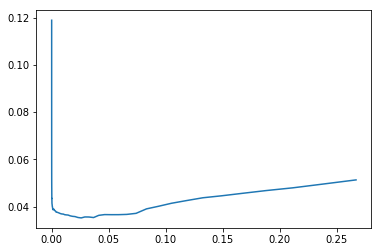

In [14]:
start_ix = 5
plt.plot(lrs, epoch_smooth_losses)

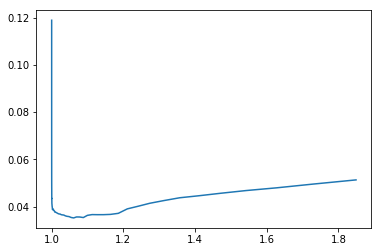

In [16]:
plt.plot([10**lr for lr in lrs], epoch_smooth_losses)

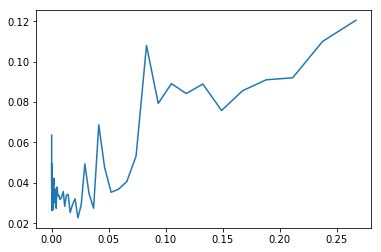

In [18]:
plt.plot(lrs, epoch_loss)

In [2]:
ix

NameError: name 'ix' is not defined

In [ ]:
def find_lr(init_value = 1e-8, final_value=10., beta = 0.98):
    num = 300 #len(trn_loader)-1
    mult = (final_value / init_value) ** (1/num)
    lr = init_value
    opt.param_groups[0]['lr'] = lr
    
    
    avg_loss = 0.
    best_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    for data in trn_loader:
        batch_num += 1
        #As before, get the loss for this mini-batch of inputs/outputs
        inputs,labels = data
        inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        #Compute the smoothed loss
        avg_loss = beta * avg_loss + (1-beta) *loss.data[0]
        smoothed_loss = avg_loss / (1 - beta**batch_num)
        
        #Stop if the loss is exploding
        if batch_num > 1 and smoothed_loss > 4 * best_loss:
            return log_lrs, losses
        
        #Record the best loss
        if smoothed_loss < best_loss or batch_num==1:
            best_loss = smoothed_loss
            
        #Store the values
        losses.append(smoothed_loss)
        log_lrs.append(math.log10(lr))
        
        #Do the SGD step
        loss.backward()
        optimizer.step()
        #Update the lr for the next step
        lr *= mult
        optimizer.param_groups[0]['lr'] = lr
    return log_lrs, losses